In [2]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import rasterio as rio
from rasterio.enums import Resampling
import json
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from PIL import ImageColor
import skimage as ski
from skimage.exposure import rescale_intensity
import scipy
from rasterio.features import shapes
import rasterio.plot as rplot

***Data Preparation***

In [3]:
sample_dr = r"C:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\Bands_Indices_Sample_Data.geojson"
raster_dr = r"C:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\sentinel2_2024cc30.tif"

In [4]:
Data = gpd.read_file(sample_dr)
Data 

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,NDBI,Class,geometry
0,0.0338,0.0380,0.0552,0.0405,0.0381,0.0193,0.0210,0.0179,0.0158,0.0111,0.0118,0.0108,-0.386986,0.205387,-0.205387,1,POINT (-91.19764 30.48437)
1,0.0335,0.0367,0.0521,0.0366,0.0341,0.0204,0.0205,0.0190,0.0145,0.0107,0.0136,0.0104,-0.316547,0.165644,-0.165644,1,POINT (-91.19854 30.48267)
2,0.0336,0.0367,0.0539,0.0377,0.0333,0.0201,0.0199,0.0179,0.0156,0.0160,0.0118,0.0089,-0.356115,0.205387,-0.205387,1,POINT (-91.1989 30.48159)
3,0.0339,0.0378,0.0556,0.0402,0.0391,0.0208,0.0212,0.0197,0.0169,0.0110,0.0124,0.0118,-0.342237,0.227414,-0.227414,1,POINT (-91.19629 30.48384)
4,0.0347,0.0390,0.0570,0.0437,0.0413,0.0216,0.0215,0.0204,0.0170,0.0127,0.0132,0.0124,-0.363495,0.214286,-0.214286,1,POINT (-91.19629 30.48177)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0.0537,0.0917,0.0972,0.1056,0.1142,0.1397,0.1434,0.1343,0.1633,0.2172,0.1915,0.1507,0.119633,-0.175568,0.175568,3,POINT (-91.23591 30.43658)
1121,0.0541,0.0937,0.1042,0.1186,0.1396,0.2060,0.2159,0.1846,0.2546,0.2427,0.2665,0.1926,0.217678,-0.181556,0.181556,3,POINT (-91.23771 30.43712)
1122,0.0463,0.0451,0.0682,0.0772,0.1137,0.1571,0.1843,0.1880,0.2070,0.2366,0.2382,0.1504,0.417798,-0.117785,0.117785,3,POINT (-91.23842 30.43766)
1123,0.0623,0.0741,0.0965,0.1262,0.1430,0.1658,0.1755,0.1848,0.1911,0.1827,0.3008,0.2502,0.188424,-0.238880,0.238880,3,POINT (-91.23025 30.43991)


In [5]:
# Define the mapping
class_mapping = {1: 'waterbody', 2: 'built_up', 3: 'bareland'}

# Add a new column 'Class_Label' based on the mapping
Data['Class_Label'] = Data['Class'].map(class_mapping)

# Display the updated Data
Data.head()

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,NDBI,Class,geometry,Class_Label
0,0.0338,0.0380,0.0552,0.0405,0.0381,0.0193,0.0210,0.0179,0.0158,0.0111,0.0118,0.0108,-0.386986,0.205387,-0.205387,1,POINT (-91.19764 30.48437),waterbody
1,0.0335,0.0367,0.0521,0.0366,0.0341,0.0204,0.0205,0.0190,0.0145,0.0107,0.0136,0.0104,-0.316547,0.165644,-0.165644,1,POINT (-91.19854 30.48267),waterbody
2,0.0336,0.0367,0.0539,0.0377,0.0333,0.0201,0.0199,0.0179,0.0156,0.0160,0.0118,0.0089,-0.356115,0.205387,-0.205387,1,POINT (-91.1989 30.48159),waterbody
3,0.0339,0.0378,0.0556,0.0402,0.0391,0.0208,0.0212,0.0197,0.0169,0.0110,0.0124,0.0118,-0.342237,0.227414,-0.227414,1,POINT (-91.19629 30.48384),waterbody
4,0.0347,0.0390,0.0570,0.0437,0.0413,0.0216,0.0215,0.0204,0.0170,0.0127,0.0132,0.0124,-0.363495,0.214286,-0.214286,1,POINT (-91.19629 30.48177),waterbody


In [6]:
# Check if the columns exist before dropping them
columns_to_drop = ['Class', 'geometry']
existing_columns_to_drop = [col for col in columns_to_drop if col in Data.columns]

if existing_columns_to_drop:
	Data = Data.drop(columns=existing_columns_to_drop)

Data

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,NDBI,Class_Label
0,0.0338,0.0380,0.0552,0.0405,0.0381,0.0193,0.0210,0.0179,0.0158,0.0111,0.0118,0.0108,-0.386986,0.205387,-0.205387,waterbody
1,0.0335,0.0367,0.0521,0.0366,0.0341,0.0204,0.0205,0.0190,0.0145,0.0107,0.0136,0.0104,-0.316547,0.165644,-0.165644,waterbody
2,0.0336,0.0367,0.0539,0.0377,0.0333,0.0201,0.0199,0.0179,0.0156,0.0160,0.0118,0.0089,-0.356115,0.205387,-0.205387,waterbody
3,0.0339,0.0378,0.0556,0.0402,0.0391,0.0208,0.0212,0.0197,0.0169,0.0110,0.0124,0.0118,-0.342237,0.227414,-0.227414,waterbody
4,0.0347,0.0390,0.0570,0.0437,0.0413,0.0216,0.0215,0.0204,0.0170,0.0127,0.0132,0.0124,-0.363495,0.214286,-0.214286,waterbody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0.0537,0.0917,0.0972,0.1056,0.1142,0.1397,0.1434,0.1343,0.1633,0.2172,0.1915,0.1507,0.119633,-0.175568,0.175568,bareland
1121,0.0541,0.0937,0.1042,0.1186,0.1396,0.2060,0.2159,0.1846,0.2546,0.2427,0.2665,0.1926,0.217678,-0.181556,0.181556,bareland
1122,0.0463,0.0451,0.0682,0.0772,0.1137,0.1571,0.1843,0.1880,0.2070,0.2366,0.2382,0.1504,0.417798,-0.117785,0.117785,bareland
1123,0.0623,0.0741,0.0965,0.1262,0.1430,0.1658,0.1755,0.1848,0.1911,0.1827,0.3008,0.2502,0.188424,-0.238880,0.238880,bareland


In [7]:
# Get statistics for each column except 'Class_Label'
statistics = Data.drop(columns=['Class_Label']).describe()

# Get variance for each column except 'Class_Label'
variance = Data.drop(columns=['Class_Label']).var()

# Append variance to the statistics table
statistics.loc['variance'] = variance

# Convert the statistics with variance to a dataframe
statistics_df = pd.DataFrame(statistics)
statistics_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,NDBI
count,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.065237,0.071687,0.097414,0.098782,0.124888,0.155020,0.170333,0.174244,0.180561,0.186453,0.163604,0.121237,0.133857,0.100500,-0.100500
std,0.048708,0.067706,0.070701,0.084117,0.086324,0.110835,0.122431,0.131205,0.134636,0.121929,0.135832,0.114738,0.387665,0.235962,0.235962
min,0.015400,0.012300,0.019500,0.015800,0.022000,0.015700,0.015500,0.009800,0.010900,0.008100,0.007100,0.006800,-0.505495,-0.508353,-0.860854
25%,0.035400,0.037700,0.055700,0.041100,0.048300,0.030900,0.033100,0.030700,0.024700,0.054600,0.018600,0.014800,-0.289233,-0.079427,-0.236246
50%,0.045100,0.047200,0.078800,0.074500,0.114200,0.177400,0.192800,0.196600,0.206900,0.211300,0.177900,0.106900,0.116856,0.104089,-0.104089
75%,0.078500,0.084600,0.109600,0.130800,0.161000,0.223900,0.249300,0.262000,0.274700,0.270400,0.263500,0.193100,0.424648,0.236246,0.079427
max,0.428100,0.600000,0.650400,0.708000,0.747600,0.721200,0.720200,0.732000,0.721500,0.673100,0.787700,0.852900,0.887646,0.860854,0.508353
variance,0.002372,0.004584,0.004999,0.007076,0.007452,0.012284,0.014989,0.017215,0.018127,0.014867,0.018450,0.013165,0.150284,0.055678,0.055678


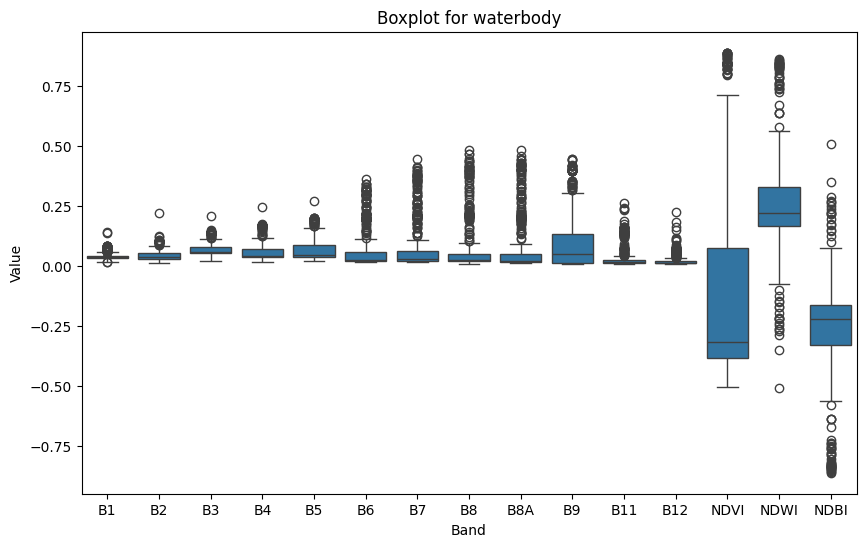

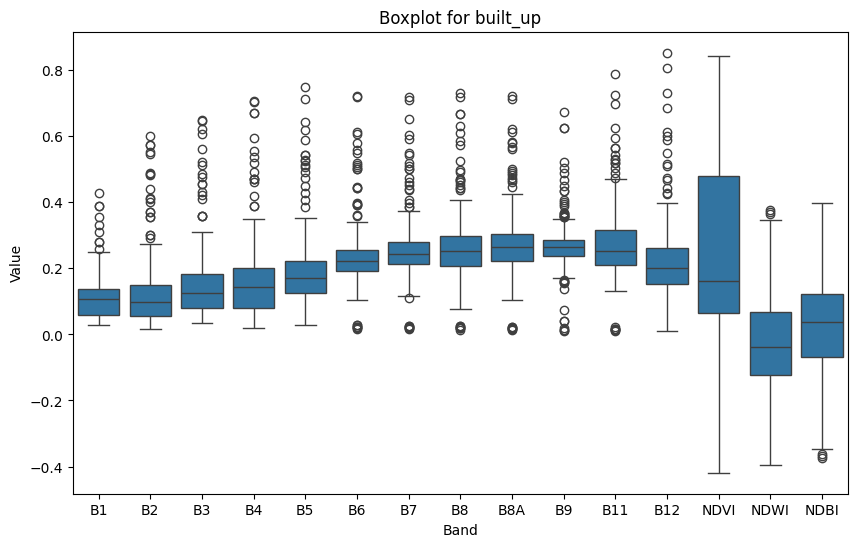

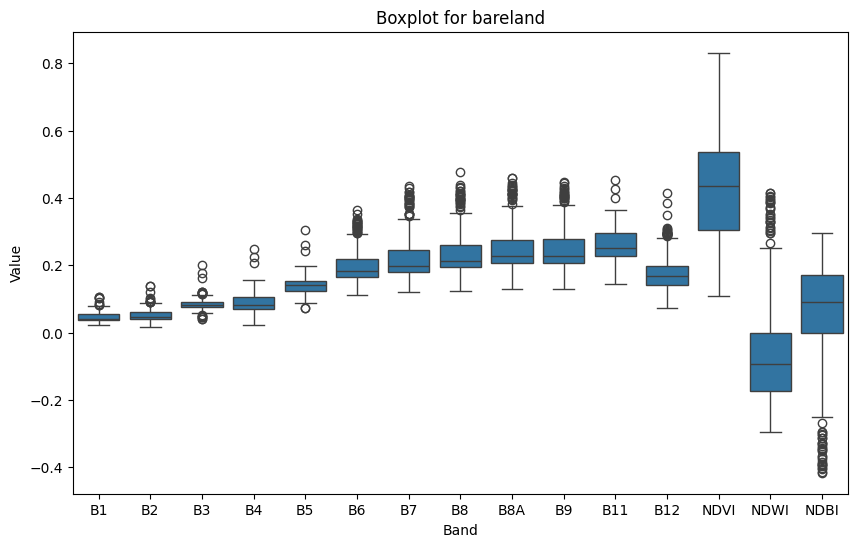

In [10]:
import seaborn as sns

# Melt the Data dataframe
melted_data = pd.melt(Data, id_vars=['Class_Label'], var_name='Band', value_name='Value')

# Get unique class labels
unique_class_labels = Data['Class_Label'].unique()

# Loop through each class label and create a separate figure
for label in unique_class_labels:
    plt.figure(figsize=(10, 6))
    subset = melted_data[melted_data['Class_Label'] == label]
    sns.boxplot(x='Band', y='Value', data=subset)
    plt.title(f'Boxplot for {label}')
    plt.show()


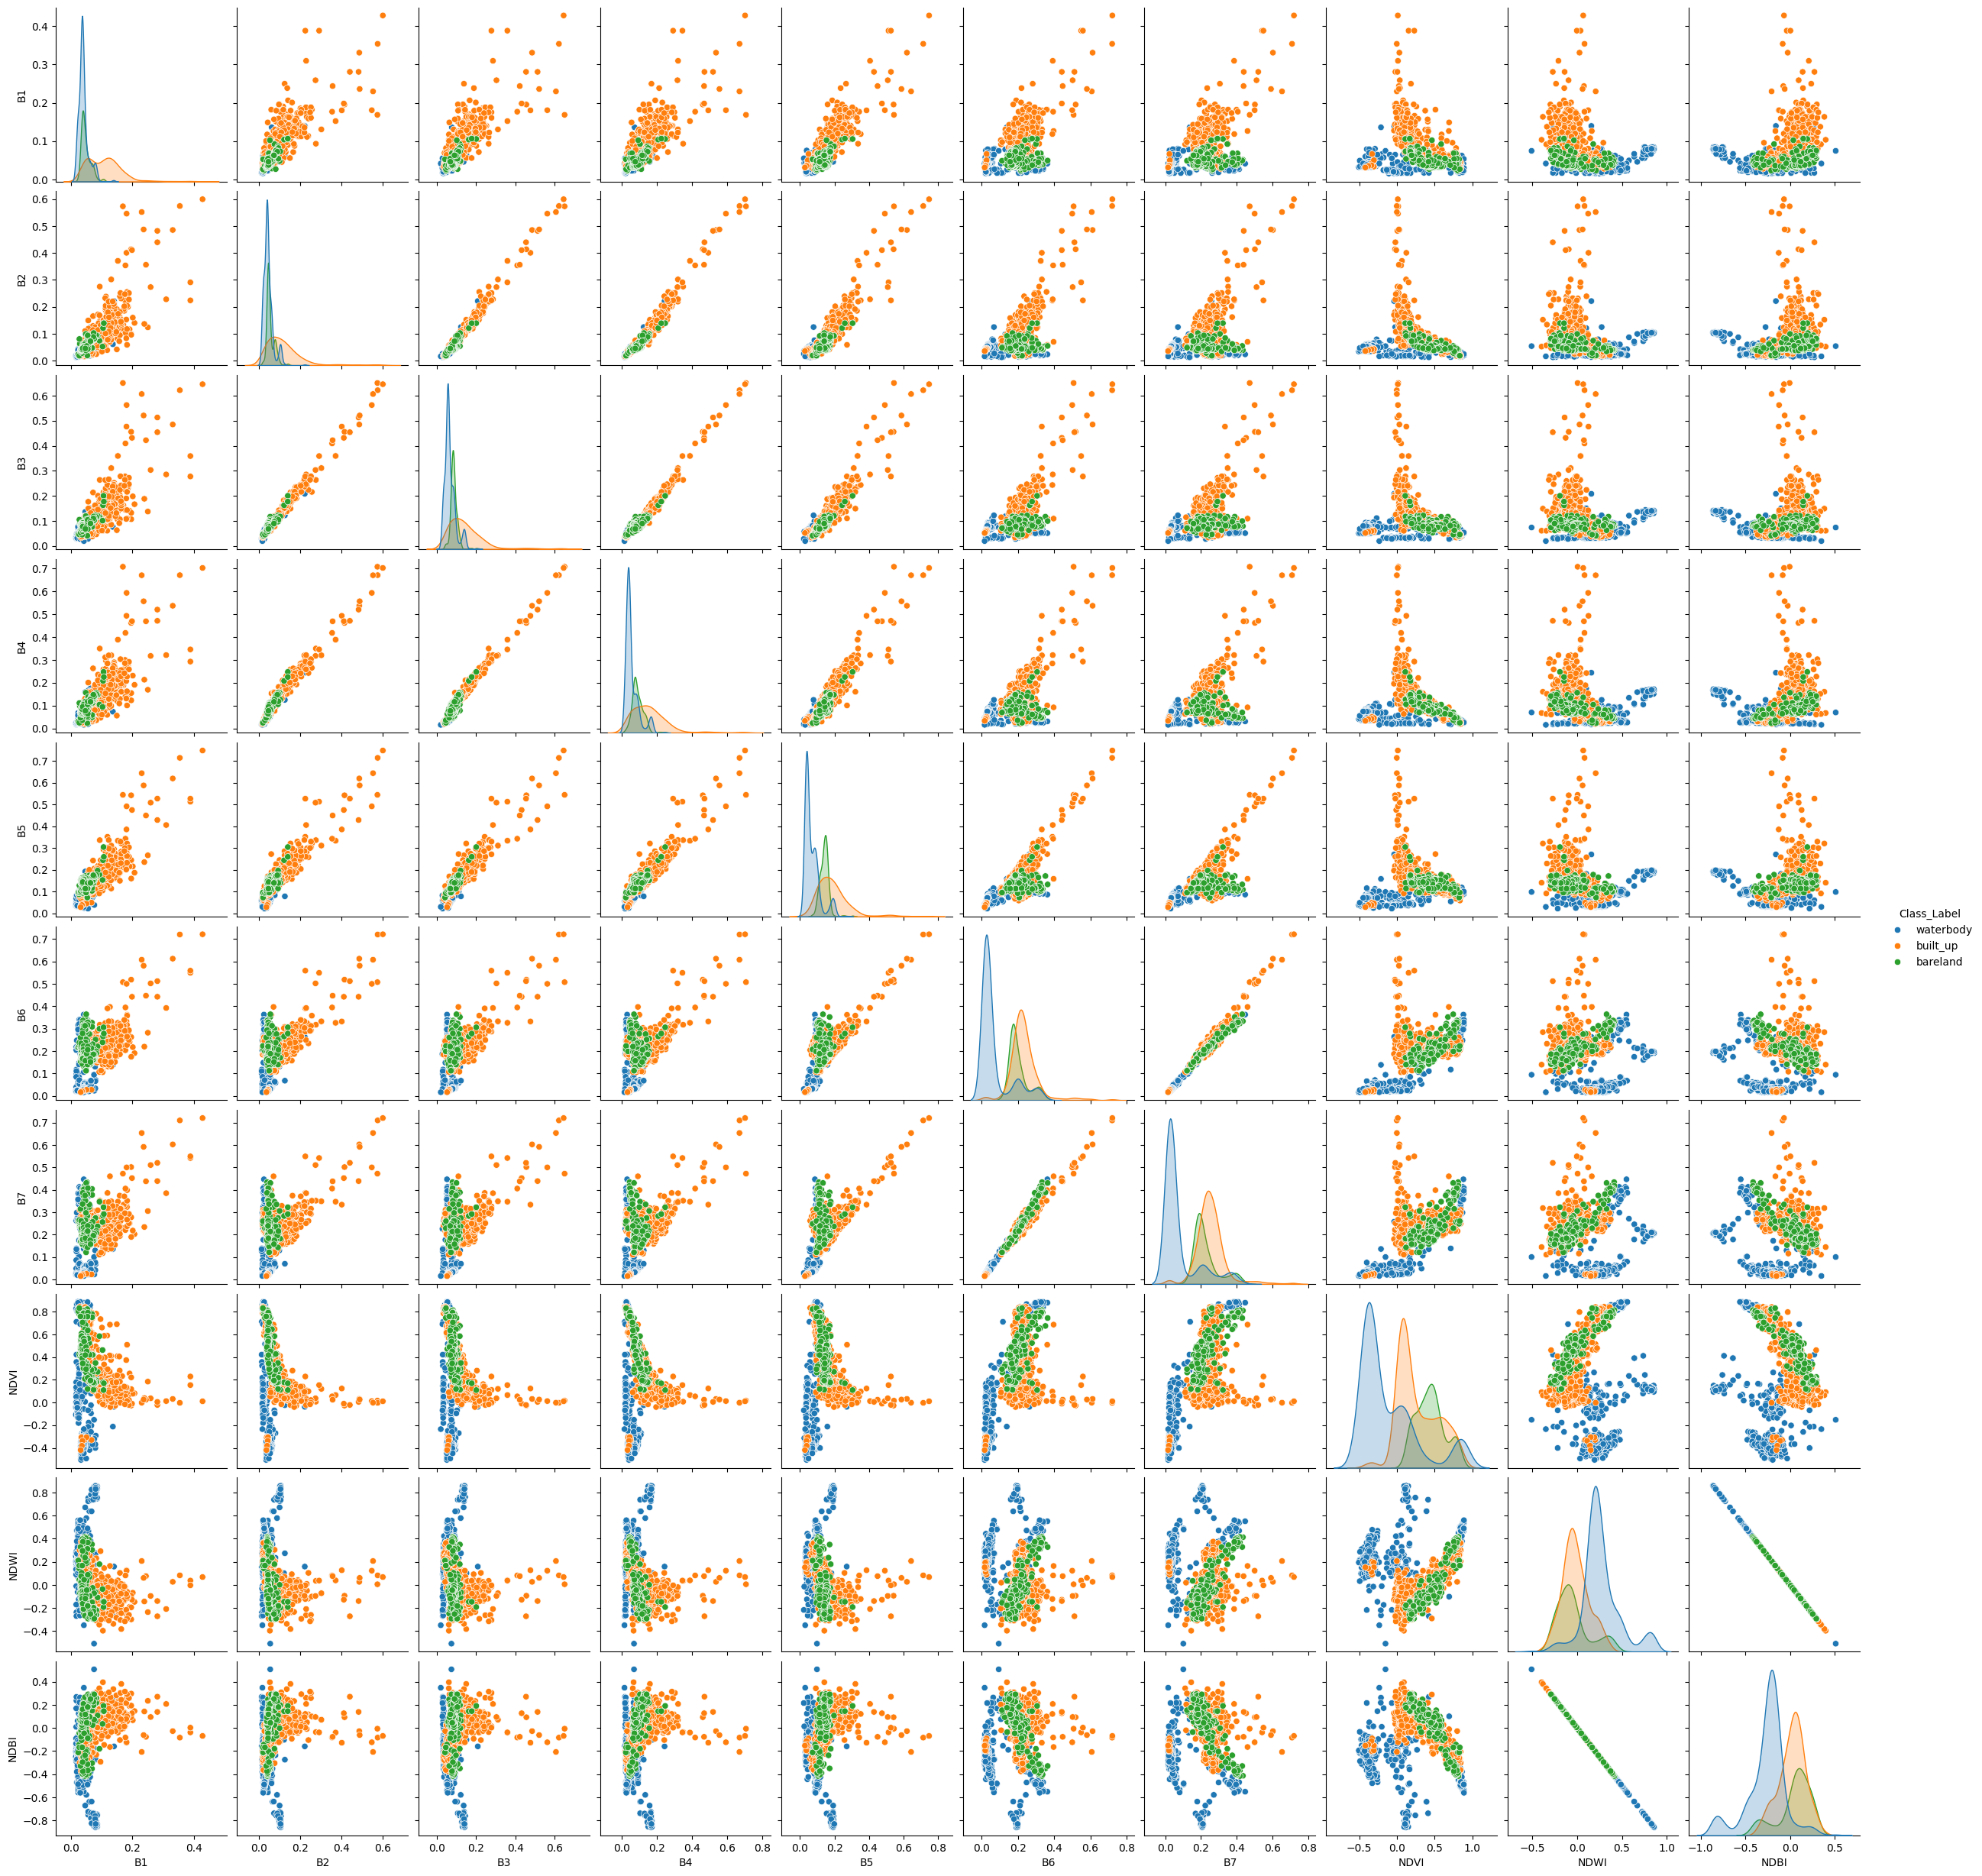

In [11]:
# Ensure 'Class_Label' column is present in the Data dataframe
if 'Class_Label' not in Data.columns:
    class_mapping = {1: 'waterbody', 2: 'built_up', 3: 'bareland'}
    Data['Class_Label'] = Data['Class'].map(class_mapping)

# Create the pairplot
sns.pairplot(Data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'NDWI', 'NDBI', 'Class_Label']],
             hue="Class_Label", diag_kind="kde")

Accuracy: 88.17


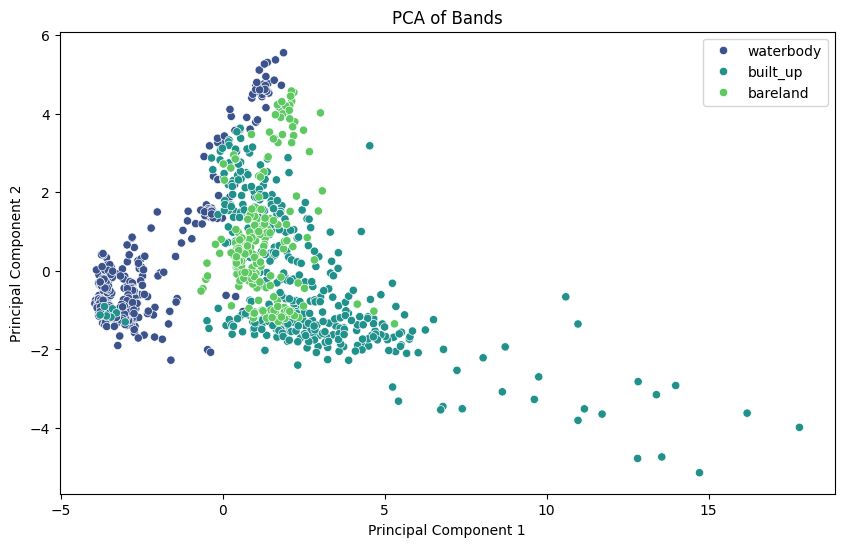

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Extract features and labels
X = Data.drop(columns=['Class_Label'])
y = Data['Class_Label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Class_Label'] = y.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(principal_components, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy = accuracy * 100
print(f'Accuracy: {accuracy:.2f}')

# Plot the PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Class_Label', data=pca_df, palette='viridis')
plt.title('PCA of Bands')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [13]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,NDVI,NDWI,NDBI
0,-0.645714,-0.497764,-0.597349,-0.693174,-1.005823,-1.225062,-1.220274,-1.192128,-1.224291,-1.438793,-1.118085,-0.962944,-1.344139,0.444706,-0.444706
1,-0.651876,-0.516973,-0.641216,-0.739559,-1.052181,-1.215133,-1.224360,-1.183741,-1.233951,-1.442075,-1.104828,-0.966432,-1.162356,0.276201,-0.276201
2,-0.649822,-0.516973,-0.615745,-0.726476,-1.061452,-1.217841,-1.229262,-1.192128,-1.225778,-1.398587,-1.118085,-0.979511,-1.264469,0.444706,-0.444706
3,-0.643660,-0.500719,-0.591689,-0.696743,-0.994234,-1.211522,-1.218640,-1.178403,-1.216118,-1.439613,-1.113666,-0.954224,-1.228654,0.538098,-0.538098
4,-0.627228,-0.482987,-0.571879,-0.655115,-0.968737,-1.204301,-1.216188,-1.173066,-1.215375,-1.425664,-1.107774,-0.948993,-1.283513,0.482434,-0.482434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,-0.236972,0.295723,-0.003033,0.081093,-0.123869,-0.138283,-0.220083,-0.304575,-0.128261,0.252286,0.205465,0.256899,-0.036708,-1.170487,1.170487
1121,-0.228756,0.325275,0.096020,0.235708,0.170502,0.460168,0.372351,0.078964,0.550164,0.461517,0.757864,0.622241,0.216316,-1.195877,1.195877
1122,-0.388967,-0.392852,-0.413394,-0.256683,-0.129663,0.018777,0.114131,0.104889,0.196462,0.411465,0.549426,0.254283,0.732764,-0.925496,0.925496
1123,-0.060330,0.035660,-0.012938,0.326099,0.209906,0.097306,0.042222,0.080489,0.078313,-0.030792,1.010495,1.124478,0.140821,-1.438920,1.438920


In [14]:
y = pd.DataFrame(y, columns=['Class_Label'])
y

,Class_Label
0,waterbody
1,waterbody
2,waterbody
3,waterbody
4,waterbody
...,...
1120,bareland
1121,bareland
1122,bareland
1123,bareland


In [15]:
y['Class_Label'] = y['Class_Label'].map({'waterbody': 0, 'built_up': 1, 'bareland': 2}).astype(int)
print(y)

      Class_Label
0               0
1               0
2               0
3               0
4               0
...           ...
1120            2
1121            2
1122            2
1123            2
1124            2

[1125 rows x 1 columns]


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 0)

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [22]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RF', RandomForestClassifier()))

c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kangah\Desktop\

LR: 0.906218
LDA: 0.881246
KNN: 0.937129


c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kangah\Desktop\Education\Machine Learning codes\

CART: 0.925280
NB: 0.810140
SVM: 0.947815


c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kangah\Desktop\Education\Machine Learning codes\ML_Project\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kangah\Desktop\Education\Machine Learning code

RF: 0.948978


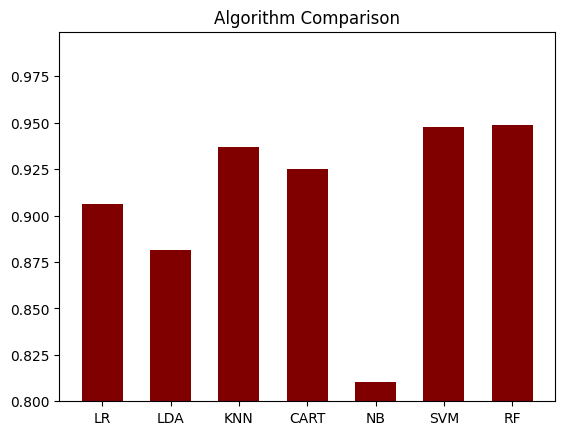

In [23]:
results = []
names = []
res = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=None)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    res.append(cv_results.mean())
    print('%s: %f' % (name, cv_results.mean()))

plt.ylim(.800, .999)
plt.bar(names, res, color ='maroon', width = 0.6)

plt.title('Algorithm Comparison')
plt.show()